# Data preparation

Prepare data for further processing.
Steps:
- discretizing data (temporal and spatial)
- encoding of categorical values
- dropping of not necessary columns
- persisting the prepared dataset as 'trips_prepared.hdf5'

Data description: https://data.cityofchicago.org/Transportation/Taxi-Trips-2014/66as-63gf


In [1]:
import vaex

Load dataset

In [2]:
df_trips = vaex.open("data/trips/trips.hdf5")

In [3]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip End Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Pickup Census Tract,float64,,,
Dropoff Census Tract,float64,,,
Pickup Community Area,float64,,,
Dropoff Community Area,float64,,,


In [4]:
df_trips.describe()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
data_type,string,large_string,string,string,float64,float64,float64,float64,float64,float64,...,float64,float64,string,string,float64,float64,string,float64,float64,string
count,37395436,37395079,37395436,37389567,37243185,37395384,25050728,24886904,32799394,32130074,...,37395208,37395208,37395436,31844863,32801555,32801555,32801555,32200561,32200561,32200561
NA,0,357,0,5869,152251,52,12344708,12508532,4596042,5265362,...,228,228,0,5550573,4593881,4593881,4593881,5194875,5194875,5194875
mean,--,--,--,--,738.3478666231151,2.813339689726566,17031344427.136786,17031341742.674646,21.595463349109437,21.015601520245486,...,0.8310885803870877,14.145692225326247,--,--,41.90364831173076,-87.65692684811735,--,41.90365339890973,-87.65566149906856,--
std,--,--,--,--,1180.184607,5.382278,335436.156238,331583.351476,18.904575,17.88967,...,22.978515,46.635981,--,--,0.037528,0.064712,--,0.038822,0.058391,--
min,--,--,--,--,0.0,0.0,17031010100.0,17031010100.0,1.0,1.0,...,0.0,0.0,--,--,41.660136,-87.913625,--,41.660136,-87.913625,--
max,--,--,--,--,86340.0,1530.4,17031990000.0,17031990000.0,77.0,77.0,...,9989.05,9999.82,--,--,42.021224,-87.534903,--,42.021224,-87.534903,--


## Discretize Data

Temporal 

In [5]:
import numpy as np
from datetime import datetime


def convert_to_datetime(date_string):
    return np.datetime64(datetime.strptime(str(date_string), '%m/%d/%Y %I:%M:%S %p')) if date_string else None


df_trips['ts_start']  = df_trips['Trip Start Timestamp'].apply(convert_to_datetime)
df_trips['ts_end']    = df_trips['Trip End Timestamp'].apply(convert_to_datetime)


# Trip Seconds includes empty cells. If the cell is empty, a trip duration is calculated. Be aware, that it's an estimation since timestamps are rounded to the quarter of an hour
df_trips['Trip Seconds'] = df_trips['Trip Seconds'] if df_trips['Trip Seconds'] else (df_trips['ts_end'] - df_trips['ts_start'])/ np.timedelta64(1, 's')

In [6]:
df_trips['Trip Seconds']

Expression = df['Trip Seconds']
Length: 37,395,436 dtype: float64 (expression)
----------------------------------------------
       0  1080
       1  1080
       2   720
       3   480
       4     0
     ...      
37395431   900
37395432   540
37395433   240
37395434   360
37395435   840

In [7]:
# add hourly data including cyclical features for periodically occurring features (hours, days)
# cyclical features are projected to a circle to ensure equal distances between hours or week days when the day or week changes (12 am -> 1 am or sunday -> monday)
df_trips['start_day']          = df_trips['ts_start'].dt.floor('D')
df_trips['start_weekday']      = df_trips['ts_start'].dt.dayofweek
df_trips['start_weekday_sin']  = np.sin(df_trips['start_weekday']*(2.*np.pi/7))
df_trips['start_weekday_cos']  = np.cos(df_trips['start_weekday']*(2.*np.pi/7))
df_trips['start_month']        = df_trips['ts_start'].dt.month
# Hourly features for grouping the data on different granularities (1h/4h/6h bins) 
df_trips['ts_start_1_hour']  = df_trips['ts_start'].dt.floor('1h')
df_trips['start_1_hour']     = df_trips['ts_start'].dt.hour
df_trips['start_1_hour_sin'] = np.sin(df_trips['start_1_hour']*(2.*np.pi/24))
df_trips['start_1_hour_cos'] = np.cos(df_trips['start_1_hour']*(2.*np.pi/24))
df_trips['ts_start_2_hour']  = df_trips['ts_start'].dt.floor('2h')
df_trips['start_2_hour']     = df_trips['ts_start'].dt.hour
df_trips['start_2_hour_sin'] = np.sin(df_trips['start_2_hour']*(2.*np.pi/12))
df_trips['start_2_hour_cos'] = np.cos(df_trips['start_2_hour']*(2.*np.pi/12))
df_trips['ts_start_4_hour']  = df_trips['ts_start'].dt.floor('4h')
df_trips['start_4_hour']     = df_trips['ts_start'].dt.floor('4h').dt.hour
df_trips['start_4_hour_sin'] = np.sin(df_trips['start_4_hour']*(2.*np.pi/6))
df_trips['start_4_hour_cos'] = np.cos(df_trips['start_4_hour']*(2.*np.pi/6))
df_trips['ts_start_6_hour']  = df_trips['ts_start'].dt.floor('6h')
df_trips['start_6_hour']     = df_trips['ts_start'].dt.floor('6h').dt.hour
df_trips['start_6_hour_sin'] = np.sin(df_trips['start_6_hour']*(2.*np.pi/4))
df_trips['start_6_hour_cos'] = np.cos(df_trips['start_6_hour']*(2.*np.pi/4))

Exemplary scatter plots of the cyclical features (ts_start_1_hour and start_weekday)

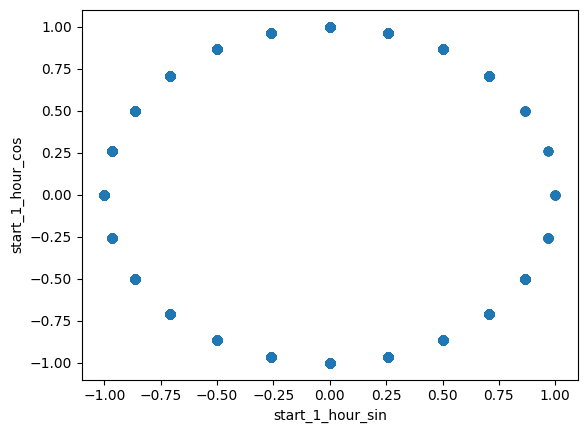

In [8]:
# exemplary plot of the cyclical feature of ts_start_1_hour
df_trips[:5000].viz.scatter(df_trips['start_1_hour_sin'], df_trips['start_1_hour_cos']) 

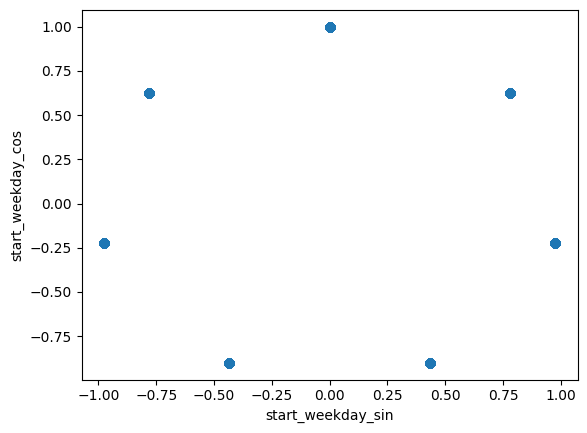

In [9]:
# exemplary plot of the cyclical feature of start_weekday
df_trips[:5000].viz.scatter(df_trips['start_weekday_sin'], df_trips['start_weekday_cos']) 

Spatial

In [10]:
import h3
from shapely import Polygon 

# docu resolution https://h3geo.org/docs/core-library/restable/

def scalar_convert_to_hex_id (lat, lon, resolution):
        hex_id = h3.geo_to_h3(lat, lon, resolution)
        return hex_id if hex_id != "0" else None

vec_convert_to_hex = np.vectorize(scalar_convert_to_hex_id)

@vaex.register_function(on_expression=False)
def convert_to_hex_id (lat, lon, resolution):
        return vec_convert_to_hex(lat, lon, resolution)

In [11]:
df_trips['pickup_hex_5']   = df_trips.func.convert_to_hex_id(df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Longitude'],  5)
df_trips['dropoff_hex_5']  = df_trips.func.convert_to_hex_id(df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Longitude'], 5)
df_trips['pickup_hex_6']   = df_trips.func.convert_to_hex_id(df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Longitude'],  6)
df_trips['dropoff_hex_6']  = df_trips.func.convert_to_hex_id(df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Longitude'], 6)
df_trips['pickup_hex_7']   = df_trips.func.convert_to_hex_id(df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Longitude'],  7)
df_trips['dropoff_hex_7']  = df_trips.func.convert_to_hex_id(df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Longitude'], 7)
df_trips['pickup_hex_8']   = df_trips.func.convert_to_hex_id(df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Longitude'],  8)
df_trips['dropoff_hex_8']  = df_trips.func.convert_to_hex_id(df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Longitude'], 8)
df_trips['pickup_hex_9']   = df_trips.func.convert_to_hex_id(df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Longitude'],  9)
df_trips['dropoff_hex_9']  = df_trips.func.convert_to_hex_id(df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Longitude'], 9)

In [12]:
df_trips

#,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,ts_start,ts_end,start_day,start_weekday,start_weekday_sin,start_weekday_cos,start_month,ts_start_1_hour,start_1_hour,start_1_hour_sin,start_1_hour_cos,ts_start_2_hour,start_2_hour,start_2_hour_sin,start_2_hour_cos,ts_start_4_hour,start_4_hour,start_4_hour_sin,start_4_hour_cos,ts_start_6_hour,start_6_hour,start_6_hour_sin,start_6_hour_cos,pickup_hex_5,dropoff_hex_5,pickup_hex_6,dropoff_hex_6,pickup_hex_7,dropoff_hex_7,pickup_hex_8,dropoff_hex_8,pickup_hex_9,dropoff_hex_9
0,506646dd0685bd55094f1b7dfac97cf3b07b6126,'1099c684f9da1ac1d0dd253d394f1c8dad37bc1a53d944d...,05/17/2014 10:45:00 AM,05/17/2014 11:00:00 AM,1080.0,7.0,17031281900.0,17031061100.0,28.0,6.0,17.45,0.0,0.0,1.5,18.95,Cash,Taxi Affiliation Services,41.879255084,-87.642648998,POINT (-87.642648998 41.8792550844),41.949139771,-87.656803909,POINT (-87.6568039088 41.9491397709),2014-05-17 10:45:00.000000,2014-05-17 11:00:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-17 10:00:00.000000,10,0.5000000000000003,-0.8660254037844385,2014-05-17 10:00:00.000000,10,-0.866025403784439,0.49999999999999933,2014-05-17 08:00:00.000000,8,0.8660254037844392,-0.4999999999999992,2014-05-17 06:00:00.000000,6,3.6739403974420594e-16,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c17ffffff,872664c1affffff,872664c16ffffff,882664c1adfffff,882664c161fffff,892664c1acfffff,892664c1617ffff
1,1462669f59c3b5a1730e8a5f511a4102d1998c21,'379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a03...,04/17/2014 06:30:00 PM,04/17/2014 07:00:00 PM,1080.0,3.0,nan,17031841100.0,nan,34.0,11.45,0.0,0.0,1.0,12.45,Cash,Taxi Affiliation Services,nan,nan,--,41.851017824,-87.635091856,POINT (-87.6350918563 41.8510178239),2014-04-17 18:30:00.000000,2014-04-17 19:00:00.000000,2014-04-17 00:00:00.000000,3,0.43388373911755823,-0.900968867902419,4,2014-04-17 18:00:00.000000,18,-1.0,-1.8369701987210297e-16,2014-04-17 18:00:00.000000,18,3.6739403974420594e-16,-1.0,2014-04-17 16:00:00.000000,16,-0.8660254037844377,-0.5000000000000016,2014-04-17 18:00:00.000000,18,1.102182119232618e-15,-1.0,None,852664cffffffff,None,862664cf7ffffff,None,872664cf4ffffff,None,882664cf4bfffff,None,892664cf4afffff
2,8d699aec32ce70e3647f7b06147001d3926975cc,'6768c7ebfdee8e7e7b3f5ec44739316241895aa2f7edf10...,05/03/2014 11:30:00 PM,05/03/2014 11:45:00 PM,720.0,2.1,17031081800.0,17031081403.0,8.0,8.0,8.45,2.0,0.0,1.0,11.45,Credit Card,Dispatch Taxi Affiliation,41.89321636,-87.63784421,POINT (-87.6378442095 41.8932163595),41.890922026,-87.618868355,POINT (-87.6188683546 41.8909220259),2014-05-03 23:30:00.000000,2014-05-03 23:45:00.000000,2014-05-03 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-03 23:00:00.000000,23,-0.25881904510252157,0.9659258262890681,2014-05-03 22:00:00.000000,23,-0.5000000000000014,0.8660254037844378,2014-05-03 20:00:00.000000,20,0.8660254037844403,-0.4999999999999972,2014-05-03 18:00:00.000000,18,1.102182119232618e-15,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c1fffffff,872664c1effffff,872664c1effffff,882664c1e5fffff,882664c1e3fffff,892664c1e4fffff,892664c1e33ffff
3,ae05f6f7a766b58b059f04c7549892da4dc3cf54,'7dc01f4be54a4058ffb81098be25f52c9f1249afc88e3ef...,05/17/2014 01:30:00 AM,05/17/2014 01:45:00 AM,480.0,0.0,17031071500.0,17031062200.0,7.0,6.0,7.85,3.0,0.0,1.0,11.85,Credit Card,Taxi Affiliation Services,41.914616286,-87.631717366,POINT (-87.6317173661 41.9146162864),41.94258518,-87.656644092,POINT (-87.6566440918 41.9425851797),2014-05-17 01:30:00.000000,2014-05-17 01:45:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-17 01:00:00.00

## Analysis of string attribute sizes, lengths etc. Encoding of string categorical values for further processing

In [13]:
len(df_trips['Payment Type'].unique())

7

In [14]:
df_trips['Payment Type'].unique()

['Dispute', 'Unknown', 'Prcard', 'Cash', 'Credit Card', 'Pcard', 'No Charge']

In [15]:
len(df_trips['Company'].unique())

108

In [16]:
df_trips['Company'].unique()

['3556 - 36214 RC Andrews Cab',
 None,
 '2823 - Seung Lee',
 '3094 - G.L.B. Cab Co',
 '5074 - 54002 Ahzmi Inc',
 '4787 - Reny Cab Co',
 '3253 - 91138 Gaither Cab Co.',
 '0118 - 42111 Godfrey S.Awir',
 '3897 - 57856 Ilie Malec',
 'Blue Ribbon Taxi Association Inc.',
 '585 - Valley Cab Co',
 '4732 - Maude Lamy',
 'Blue Diamond',
 '4615 - 83503 Tyrone Henderson',
 '3385 - Eman Cab',
 'Northwest Management LLC',
 '2733 - Benny Jona',
 '2192 - Zeymane Corp',
 '4053 - Adwar H. Nikola',
 '2767 - Sayed M Badri',
 '4787 - 56058 Reny Cab Co',
 '1408 - Donald Barnes',
 'nan',
 'Flash Cab',
 '3620 - David K. Cab Corp.',
 '4053 - 40193 Adwar H. Nikola',
 '6488 - Zuha Taxi',
 '6743 - 78771 Luhak Corp',
 'Taxi Affiliation Services',
 'Chicago Medallion Management',
 '1408 - 89599 Donald Barnes',
 "3591- 63480 Chuk's Cab",
 'Suburban Dispatch LLC',
 '3385 - 23210  Eman Cab',
 'Chicago Elite Cab Corp. (Chicago Carriag',
 '3623 - 72222 Arrington Enterprises',
 '5874 - 73628 Sergey Cab Corp.',
 '0694 - 5

In [17]:
len(df_trips['Taxi ID'].unique())

7781

In [18]:
df_trips['Taxi ID'].apply(lambda x : len(x) if x != None else 0).mean()

array(127.99877803)

## Encode string columns

Encoding of the string columns reduces the size of the dataframe and need to be encoded for the ML models.

In [19]:
def generate_encoding_dict(df, column):
    # get categories to encode
    categories = df[column].unique()
    # generate output the categories are mapped to -> using a simple integer mapping 
    output = range(len(categories))
    # combine categories and output
    encoding_dict = dict(zip(categories, output))
    return encoding_dict

In [20]:
df_trips['Payment Type_encoded'] = df_trips['Payment Type'].map(generate_encoding_dict(df_trips, 'Payment Type'))
df_trips['Company_encoded']      = df_trips['Company'].map(generate_encoding_dict(df_trips, 'Company'))
df_trips['Taxi ID_encoded']      = df_trips['Taxi ID'].map(generate_encoding_dict(df_trips, 'Taxi ID'))

In [ ]:
# persist mappings
# Payment Type
df_trips.groupby(by=['Payment Type','Payment Type_encoded']).agg('count').export_hdf5("data/trips/trips_mapping_payment_type.hdf5", progress=True)
# Company
df_trips.groupby(by=['Company','Company_encoded']).agg('count').export_hdf5("data/trips/trips_mapping_company.hdf5", progress=True)
# Taxi ID
df_trips.groupby(by=['Taxi ID','Taxi ID_encoded']).agg('count').export_hdf5("data/trips/trips_mapping_taxi_id.hdf5", progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.06s =  0.0m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     0.08s =  0.0m =  0.0h
 

In [ ]:
def transpose_category(df, column_name, category):
    df[column_name + '_' + category] = df[column_name].apply(lambda x: 1 if x == category else 0)

In [ ]:
categories = df_trips['Payment Type'].unique()
for category in categories:
    transpose_category(df_trips, 'Payment Type', category)

In [ ]:
df_trips

#,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,ts_start,ts_end,start_day,start_weekday,start_weekday_sin,start_weekday_cos,start_month,ts_start_1_hour,start_1_hour,start_1_hour_sin,start_1_hour_cos,ts_start_4_hour,start_4_hour,start_4_hour_sin,start_4_hour_cos,ts_start_6_hour,start_6_hour,start_6_hour_sin,start_6_hour_cos,pickup_hex_5,dropoff_hex_5,pickup_hex_6,dropoff_hex_6,pickup_hex_7,dropoff_hex_7,pickup_hex_8,dropoff_hex_8,pickup_hex_9,dropoff_hex_9,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Payment Type_Prcard,Payment Type_No Charge,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard
0,506646dd0685bd55094f1b7dfac97cf3b07b6126,'1099c684f9da1ac1d0dd253d394f1c8dad37bc1a53d944d...,05/17/2014 10:45:00 AM,05/17/2014 11:00:00 AM,1080.0,7.0,17031281900.0,17031061100.0,28.0,6.0,17.45,0.0,0.0,1.5,18.95,Cash,Taxi Affiliation Services,41.879255084,-87.642648998,POINT (-87.642648998 41.8792550844),41.949139771,-87.656803909,POINT (-87.6568039088 41.9491397709),2014-05-17 10:45:00.000000,2014-05-17 11:00:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-17 10:00:00.000000,10,0.5000000000000003,-0.8660254037844385,2014-05-17 08:00:00.000000,8,0.8660254037844392,-0.4999999999999992,2014-05-17 06:00:00.000000,6,3.6739403974420594e-16,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c17ffffff,872664c1affffff,872664c16ffffff,882664c1adfffff,882664c161fffff,892664c1acfffff,892664c1617ffff,4,19,4122,0,0,0,0,1,0,0
1,1462669f59c3b5a1730e8a5f511a4102d1998c21,'379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a03...,04/17/2014 06:30:00 PM,04/17/2014 07:00:00 PM,1080.0,3.0,nan,17031841100.0,nan,34.0,11.45,0.0,0.0,1.0,12.45,Cash,Taxi Affiliation Services,nan,nan,--,41.851017824,-87.635091856,POINT (-87.6350918563 41.8510178239),2014-04-17 18:30:00.000000,2014-04-17 19:00:00.000000,2014-04-17 00:00:00.000000,3,0.43388373911755823,-0.900968867902419,4,2014-04-17 18:00:00.000000,18,-1.0,-1.8369701987210297e-16,2014-04-17 16:00:00.000000,16,-0.8660254037844377,-0.5000000000000016,2014-04-17 18:00:00.000000,18,1.102182119232618e-15,-1.0,None,852664cffffffff,None,862664cf7ffffff,None,872664cf4ffffff,None,882664cf4bfffff,None,892664cf4afffff,4,19,2378,0,0,0,0,1,0,0
2,8d699aec32ce70e3647f7b06147001d3926975cc,'6768c7ebfdee8e7e7b3f5ec44739316241895aa2f7edf10...,05/03/2014 11:30:00 PM,05/03/2014 11:45:00 PM,720.0,2.1,17031081800.0,17031081403.0,8.0,8.0,8.45,2.0,0.0,1.0,11.45,Credit Card,Dispatch Taxi Affiliation,41.89321636,-87.63784421,POINT (-87.6378442095 41.8932163595),41.890922026,-87.618868355,POINT (-87.6188683546 41.8909220259),2014-05-03 23:30:00.000000,2014-05-03 23:45:00.000000,2014-05-03 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-03 23:00:00.000000,23,-0.25881904510252157,0.9659258262890681,2014-05-03 20:00:00.000000,20,0.8660254037844403,-0.4999999999999972,2014-05-03 18:00:00.000000,18,1.102182119232618e-15,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c1fffffff,872664c1effffff,872664c1effffff,882664c1e5fffff,882664c1e3fffff,892664c1e4fffff,892664c1e33ffff,5,34,4734,0,0,0,0,0,1,0
3,ae05f6f7a766b58b059f04c7549892da4dc3cf54,'7dc01f4be54a4058ffb81098be25f52c9f1249afc88e3ef...,05/17/2014 01:30:00 AM,05/17/2014 01:45:00 AM,480.0,0.0,17031071500.0,17031062200.0,7.0,6.0,7.85,3.0,0.0,1.0,11.85,Credit Card,Taxi Affiliation Services,41.914616286,-87.631717366,POINT (-87.6317173661 41.9146162864),41.94258518,-87.656644092,POINT (-87.6566440918 41.9425851797),2014-05-17 01:30:00.000000,2014-05-17 01:45:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-1

## Drop redundant and not needed columns

Trip ID is an unique identifier but not needed for the further processing.
Location data is present in different formats. The encoded h3-hexagon values are used in the further processing.
All Timestamps are dropped since the time data is discretized and on an higher granularity. Start timestamp and Trip duration are sufficient for the further processing. The End timestamp is not analyzed.

In [ ]:
df_trips.drop(['Trip ID', 'Trip Start Timestamp', 'Trip End Timestamp',  'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid  Location'], inplace=True)

#,Taxi ID,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,ts_start,ts_end,start_day,start_weekday,start_weekday_sin,start_weekday_cos,start_month,ts_start_1_hour,start_1_hour,start_1_hour_sin,start_1_hour_cos,ts_start_2_hour,start_2_hour,start_2_hour_sin,start_2_hour_cos,ts_start_4_hour,start_4_hour,start_4_hour_sin,start_4_hour_cos,ts_start_6_hour,start_6_hour,start_6_hour_sin,start_6_hour_cos,pickup_hex_5,dropoff_hex_5,pickup_hex_6,dropoff_hex_6,pickup_hex_7,dropoff_hex_7,pickup_hex_8,dropoff_hex_8,pickup_hex_9,dropoff_hex_9,Payment Type_encoded,Company_encoded,Taxi ID_encoded,Payment Type_Prcard,Payment Type_No Charge,Payment Type_Dispute,Payment Type_Unknown,Payment Type_Cash,Payment Type_Credit Card,Payment Type_Pcard
0,'1099c684f9da1ac1d0dd253d394f1c8dad37bc1a53d944d...,1080.0,7.0,17031281900.0,17031061100.0,28.0,6.0,17.45,0.0,0.0,1.5,18.95,Cash,Taxi Affiliation Services,2014-05-17 10:45:00.000000,2014-05-17 11:00:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-17 10:00:00.000000,10,0.5000000000000003,-0.8660254037844385,2014-05-17 10:00:00.000000,10,-0.866025403784439,0.49999999999999933,2014-05-17 08:00:00.000000,8,0.8660254037844392,-0.4999999999999992,2014-05-17 06:00:00.000000,6,3.6739403974420594e-16,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c17ffffff,872664c1affffff,872664c16ffffff,882664c1adfffff,882664c161fffff,892664c1acfffff,892664c1617ffff,4,19,4102,0,0,0,0,1,0,0
1,'379e0fd9da136cabc9eec3aca37047bbdee373ca2ef7a03...,1080.0,3.0,nan,17031841100.0,nan,34.0,11.45,0.0,0.0,1.0,12.45,Cash,Taxi Affiliation Services,2014-04-17 18:30:00.000000,2014-04-17 19:00:00.000000,2014-04-17 00:00:00.000000,3,0.43388373911755823,-0.900968867902419,4,2014-04-17 18:00:00.000000,18,-1.0,-1.8369701987210297e-16,2014-04-17 18:00:00.000000,18,3.6739403974420594e-16,-1.0,2014-04-17 16:00:00.000000,16,-0.8660254037844377,-0.5000000000000016,2014-04-17 18:00:00.000000,18,1.102182119232618e-15,-1.0,None,852664cffffffff,None,862664cf7ffffff,None,872664cf4ffffff,None,882664cf4bfffff,None,892664cf4afffff,4,19,2360,0,0,0,0,1,0,0
2,'6768c7ebfdee8e7e7b3f5ec44739316241895aa2f7edf10...,720.0,2.1,17031081800.0,17031081403.0,8.0,8.0,8.45,2.0,0.0,1.0,11.45,Credit Card,Dispatch Taxi Affiliation,2014-05-03 23:30:00.000000,2014-05-03 23:45:00.000000,2014-05-03 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-03 23:00:00.000000,23,-0.25881904510252157,0.9659258262890681,2014-05-03 22:00:00.000000,23,-0.5000000000000014,0.8660254037844378,2014-05-03 20:00:00.000000,20,0.8660254037844403,-0.4999999999999972,2014-05-03 18:00:00.000000,18,1.102182119232618e-15,-1.0,852664c3fffffff,852664c3fffffff,862664c1fffffff,862664c1fffffff,872664c1effffff,872664c1effffff,882664c1e5fffff,882664c1e3fffff,892664c1e4fffff,892664c1e33ffff,5,34,4728,0,0,0,0,0,1,0
3,'7dc01f4be54a4058ffb81098be25f52c9f1249afc88e3ef...,480.0,0.0,17031071500.0,17031062200.0,7.0,6.0,7.85,3.0,0.0,1.0,11.85,Credit Card,Taxi Affiliation Services,2014-05-17 01:30:00.000000,2014-05-17 01:45:00.000000,2014-05-17 00:00:00.000000,5,-0.9749279121818236,-0.2225209339563146,5,2014-05-17 01:00:00.000000,1,0.25881904510252074,0.9659258262890683,2014-05-17 00:00:00.000000,1,0.49999999999999994,0.8660254037844387,2014-05-17 00:00:00.000000,0,0.0,1.0,2014-05-17 00:00:00.000000,0,0.0,1.0,852664c3fffffff,852664c3fffffff,862664c17ffffff,862664c17ffffff,872664c11ffffff,872664c16ffffff,882664c115fffff,882664c163fffff,892664c114fffff,892664c163bffff,5,19,3481,0,0,0,0,0,1,0
4,'9f87b11be025b5dcc55e9472b8c2158664c97d193cf15d9...,0.0,0.0,nan,nan,nan,nan,42.05,7.0,0.0,0.0,49.05,Credit Card,T.A.S. - Payment Only,2014-04-25 14:30:00.000000,2014-04-25 14:30:00.000000,2014-04-25 00:00:00.000000,4,-0.433883739117558,-0.9009688679024191,4,2014-04-25 14:00:00.000000,14,-0.4999999999999997,-0.8660254037844388,2014-04-25 14:00:00.000000,14,0.

## Final dataset

In [ ]:
df_trips.column_names

['Taxi ID',
 '__Trip Start Timestamp',
 '__Trip End Timestamp',
 'Trip Seconds',
 '__Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tips',
 'Tolls',
 'Extras',
 'Trip Total',
 'Payment Type',
 'Company',
 '__Pickup Centroid Latitude',
 '__Pickup Centroid Longitude',
 '__Dropoff Centroid Latitude',
 '__Dropoff Centroid Longitude',
 'ts_start',
 'ts_end',
 'start_day',
 'start_weekday',
 'start_weekday_sin',
 'start_weekday_cos',
 'start_month',
 'ts_start_1_hour',
 'start_1_hour',
 'start_1_hour_sin',
 'start_1_hour_cos',
 'ts_start_2_hour',
 'start_2_hour',
 'start_2_hour_sin',
 'start_2_hour_cos',
 'ts_start_4_hour',
 'start_4_hour',
 'start_4_hour_sin',
 'start_4_hour_cos',
 'ts_start_6_hour',
 'start_6_hour',
 'start_6_hour_sin',
 'start_6_hour_cos',
 'pickup_hex_5',
 'dropoff_hex_5',
 'pickup_hex_6',
 'dropoff_hex_6',
 'pickup_hex_7',
 'dropoff_hex_7',
 'pickup_hex_8',
 'dropoff_hex_8',


In [ ]:
df_trips_export_cols = ['Taxi ID_encoded',
                        'Company',
                        'Company_encoded',
                        'ts_start',
                        'ts_end',
                        'start_day',
                        'start_weekday',
                        'start_month',
                        'Trip Seconds',
                        'Trip Miles',
                        'Fare',
                        'Tips',
                        'Tolls',
                        'Extras',
                        'Trip Total',
                        'Payment Type',
                        'Payment Type_encoded',
                        'Pickup Census Tract',
                        'Dropoff Census Tract',
                        'Pickup Community Area', 
                        'Dropoff Community Area',
                        'pickup_hex_5',
                        'dropoff_hex_5',
                        'dropoff_hex_6',
                        'pickup_hex_6',
                        'pickup_hex_7',
                        'dropoff_hex_7',
                        'pickup_hex_8',
                        'dropoff_hex_8',
                        'pickup_hex_9',
                        'dropoff_hex_9', 
                        'ts_start_1_hour',
                        'start_1_hour',
                        'start_1_hour_sin',
                        'start_1_hour_cos',
                        'ts_start_2_hour',
                        'start_2_hour',
                        'start_2_hour_sin',
                        'start_2_hour_cos',
                        'ts_start_4_hour',
                        'start_4_hour',
                        'start_4_hour_sin',
                        'start_4_hour_cos',
                        'ts_start_6_hour',
                        'start_6_hour',
                        'start_6_hour_sin',
                        'start_6_hour_cos',  
                        'start_weekday_sin',
                        'start_weekday_cos',
                        'Payment Type_Dispute',
                        'Payment Type_Unknown',
                        'Payment Type_Prcard',
                        'Payment Type_Cash',
                        'Payment Type_Credit Card',
                        'Payment Type_Pcard',
                        'Payment Type_No Charge'
                        ]


In [ ]:
df_trips[df_trips_export_cols].info()

column,type,unit,description,expression
Taxi ID_encoded,virtual column,,,"_map(df['__Taxi ID'], map_key_hash_map_unique_2, map_choices_2, axis=None)"
Company,str,,,
Company_encoded,virtual column,,,"_map(Company, map_key_hash_map_unique_1, map_choices_1, axis=None)"
ts_start,virtual column,,,lambda_function(df['____Trip Start Timestamp'])
ts_end,virtual column,,,lambda_function_1(df['____Trip End Timestamp'])
start_day,virtual column,,,"dt_floor(ts_start, 'D')"
start_weekday,virtual column,,,dt_dayofweek(ts_start)
start_month,virtual column,,,dt_month(ts_start)
Trip Seconds,virtual column,,,df['____Trip Seconds']
Trip Miles,float64,,,


## Persist dataset as 'trips_prepared.hdf5'

In [ ]:
df_trips[df_trips_export_cols].export_hdf5("data/trips/trips_prepared.hdf5", progress=True)

export(hdf5) [----------------------------------------]  0.00% estimated time: unknown                 

export(hdf5) [########################################] 100.00% elapsed time  :  4000.72s =  66.7m =  1.1h                                                                                                                                                                                                                                                                                                                                                                                                                                                     
 

## Persist aggregated data sets (relevant for further processing)

In [ ]:
# load df_trips to avoid calculations of columns again and enable independent calculation of the different groupings

df_trips = df_trips[df_trips_export_cols] 

df_trips = vaex.open("data/trips/trips_prepared.hdf5", progress=True)

In [ ]:
aggregation = { 'demand':'count',
                'Trip Seconds':'mean', 
                'Trip Miles':'mean', 
                'Fare':'mean', 
                'Tips':'mean', 
                'Tolls':'mean', 
                'Extras':'mean', 
                'Trip Total':'mean',
                'Company_encoded':'nunique',
                'Taxi ID_encoded':'nunique',
                'Payment Type_Dispute':'sum',
                'Payment Type_Unknown':'sum',
                'Payment Type_Prcard':'sum',
                'Payment Type_Cash':'sum',
                'Payment Type_Credit Card':'sum',
                'Payment Type_Pcard':'sum',
                'Payment Type_No Charge':'sum'}

In [ ]:
def generate_grouping(df, granularity_hour, granularity_location):
    group_by  = [df['ts_start_' + str(granularity_hour) + '_hour'], df['start_' + str(granularity_hour) + '_hour'], df['start_' + str(granularity_hour) + '_hour_sin'], df['start_' + str(granularity_hour) + '_hour_cos']]
    if isinstance(granularity_location, int):
        group_by.append(df['pickup_hex_' + str(granularity_location)])
    else:
        group_by.append(df[granularity_location])
    return group_by

# group_by_general -> grouping of overarching attributes
group_by_general = [df_trips.start_day, df_trips.start_month, df_trips.start_weekday, df_trips.start_weekday_sin, df_trips.start_weekday_cos]

In [ ]:
# aggregation to 1h and resolutions 7, 8, 9
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 7), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r7.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 8), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r8.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 9), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r9.hdf5", progress=True)
# aggregation to 4h and resolutions 7, 8, 9
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 7), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r7.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 8), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r8.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 9), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r9.hdf5", progress=True)
# aggregation to 6h and resolutions 7, 8, 9
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 7), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r7.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 8), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r8.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 9), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r9.hdf5", progress=True)

# aggregation to 1h, 4h, 6h and resolution census tract
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'Pickup Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_census.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'Pickup Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_census.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'Pickup Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_census.hdf5", progress=True)

# aggregation to 1h, 4h, 6h and resolution census tract
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'Pickup Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_comArea.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'Pickup Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_comArea.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'Pickup Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_comArea.hdf5", progress=True)


groupby [########################################] 100.00% elapsed time  :    27.34s =  0.5m =  0.0h  
groupby [########################################] 100.00% elapsed time  :    29.82s =  0.5m =  0.0h 
export(hdf5) [########################################] 100.00% elapsed time  :     3.01s =  0.1m =  0.0h        
groupby [########################################] 100.00% elapsed time  :    31.44s =  0.5m =  0.0h h 
groupby [########################################] 100.00% elapsed time  :    34.01s =  0.6m =  0.0h
export(hdf5) [########################################] 100.00% elapsed time  :     4.76s =  0.1m =  0.0h          
groupby [########################################] 100.00% elapsed time  :    30.75s =  0.5m =  0.0h h 
groupby [########################################] 100.00% elapsed time  :    33.58s =  0.6m =  0.0h
 

In [ ]:
# aggregation to 1h and resolutions 7, 8, 9
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'dropoff_hex_7'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r7.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'dropoff_hex_8'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r8.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'dropoff_hex_9'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r9.hdf5", progress=True)
# aggregation to 4h and resolutions 7, 8, 9
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'dropoff_hex_7'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r7.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'dropoff_hex_8'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r8.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'dropoff_hex_9'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_r9.hdf5", progress=True)
# aggregation to 6h and resolutions 7, 8, 9
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'dropoff_hex_7'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r7.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'dropoff_hex_8''), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r8.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'dropoff_hex_9), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r9.hdf5", progress=True)

# aggregation to 1h, 4h, 6h and resolution census tract
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'Dropoff Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_census.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'Dropoff Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_census.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'Dropoff Census Tract'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_census.hdf5", progress=True)

# aggregation to 1h, 4h, 6h and resolution census tract
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 'Dropoff Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_comArea.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 4, 'Dropoff Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_4h_comArea.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 'Dropoff Community Area'), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_comArea.hdf5", progress=True)


Dataset including dropoff -> routes

In [ ]:
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 9) + [df_trips['dropoff_hex_9']], progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r9_routes.hdf5", progress=True)

groupby [########################################] 100.00% elapsed time  :    31.88s =  0.5m =  0.0h  
groupby [########################################] 100.00% elapsed time  :    37.67s =  0.6m =  0.0h
 

In [ ]:
# aggregation to 1h and resolutions 5, 6 
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 5), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r5.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 1, 6), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_1h_r6.hdf5", progress=True)

# aggregation to 2h and resolutions 5, 6
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 2, 5), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_2h_r5.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 2, 6), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_2h_r6.hdf5", progress=True)

# aggregation to 6h and resolutions 5, 6
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 5), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r5.hdf5", progress=True)
df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 6, 6), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_6h_r6.hdf5", progress=True)

# aggregation 24h and resolutions 5, 6 
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 24, 5), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_24h_r5.hdf5", progress=True)
#df_trips.groupby(by=group_by_general + generate_grouping(df_trips, 24, 6), progress=True).agg(aggregation).export_hdf5("data/trips/trips_grouped_24h_r6.hdf5", progress=True)

groupby [########################################] 100.00% elapsed time  :   205.57s =  3.4m =  0.1h        
groupby [########################################] 100.00% elapsed time  :   408.82s =  6.8m =  0.1h  
export(hdf5) [########################################] 100.00% elapsed time  :     0.40s =  0.0m =  0.0h    
groupby [########################################] 100.00% elapsed time  :   209.72s =  3.5m =  0.1h          
groupby [########################################] 100.00% elapsed time  :   412.95s =  6.9m =  0.1h
export(hdf5) [########################################] 100.00% elapsed time  :     0.42s =  0.0m =  0.0h   
 